In [25]:
''' 
模型选择/欠拟合和过拟合
对抗过拟合的技术称之为正则化
启发式技术防止过拟合
早停模型 early stopping 即较少训练迭代周期的模型

在本节中，为了给你⼀些直观的印象，我们将重点介绍⼏个倾向于影响模型泛化的因素：
1. 可调整参数的数量。当可调整参数的数量（有时称为⾃由度）很⼤时，模型往往更容易过拟合。
2. 参数采⽤的值。当权重的取值范围较⼤时，模型可能更容易过拟合。
3. 训练样本的数量。即使你的模型很简单，也很容易过拟合只包含⼀两个样本的数据集。
⽽过拟合⼀个有数百万个样本的数据集则需要⼀个极其灵活的模型。


训练集 测试集 验证集
除⾮另有明确说明，否则在这本书的实验中，我们实际上是在使⽤应该被正确地称为训练数据和验
证数据的数据集，并没有真正的测试数据集。因此，书中每次实验报告的准确度都是验证集准确度,
⽽不是测试集准确度

K折交叉验证
当训练数据稀缺时，我们甚⾄可能⽆法提供⾜够的数据来构成⼀个合适的验证集。这个问题的⼀个流⾏的解
决⽅案是采⽤K折交叉验证。这⾥，原始训练数据被分成K个不重叠的⼦集。然后执⾏K次模型训练和验证，
每次在K − 1个⼦集上进⾏训练，并在剩余的⼀个⼦集（在该轮中没有⽤于训练的⼦集）上进⾏验证。最后，
通过对K次实验的结果取平均来估计训练和验证误差。

对于许多任务，深度学习只有在有数千个训练样本时才优于线性模型
'''
# 多项式回归
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l



In [26]:
# 生成数据集 三阶多项式,高阶项为噪声,服从均值为0,标准差为0.1的正态分布
max_degree = 20 # 多项式的最⼤阶数 
n_train, n_test = 100, 100 # 训练和测试数据集⼤⼩
true_w = np.zeros(max_degree) # 分配⼤量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6]) # 三阶多项式系数,高阶系数为0

features = np.random.normal(size=(n_train + n_test, 1)) # features -> x 
# 随机正态,均值方差默认为0,1      size=(200,1) 200行1列
np.random.shuffle(features) # 打乱0维数据
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1)) 
# np.power()用于数组元素求n次方
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # gamma(n)=(n-1)!  Γ(n) = (n − 1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w) # 三阶多项式的值 即y
labels += np.random.normal(scale=0.1, size=labels.shape) # 干扰项,噪声

In [27]:
# NumPy ndarray转换为tensor 即将下述参数转化为张量
true_w, features, poly_features, labels = [torch.tensor(x, dtype=torch.float32) for x in [true_w, features, poly_features, labels]]

In [28]:
# 查看部分样本 其中poly_features20列
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.5718],
         [ 0.6703]]),
 tensor([[ 1.0000e+00, -5.7176e-01,  1.6345e-01, -3.1152e-02,  4.4528e-03,
          -5.0919e-04,  4.8522e-05, -3.9633e-06,  2.8325e-07, -1.7995e-08,
           1.0289e-09, -5.3478e-11,  2.5480e-12, -1.1207e-13,  4.5767e-15,
          -1.7445e-16,  6.2340e-18, -2.0967e-19,  6.6600e-21, -2.0041e-22],
         [ 1.0000e+00,  6.7027e-01,  2.2463e-01,  5.0187e-02,  8.4097e-03,
           1.1274e-03,  1.2594e-04,  1.2059e-05,  1.0103e-06,  7.5244e-08,
           5.0434e-09,  3.0731e-10,  1.7165e-11,  8.8501e-13,  4.2371e-14,
           1.8933e-15,  7.9315e-17,  3.1272e-18,  1.1645e-19,  4.1079e-21]]),
 tensor([3.7851, 5.3316]))

In [29]:
# 对模型进行训练和测试
def evaluate_loss(net, data_iter, loss): #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X) # net() 返回网络最后的输出y.即y_hat
        y = y.reshape(out.shape)
        l = loss(out, y) # loss() 返回交叉熵损失
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1] # l.sum() / l.numel()  损失之和/元素个数之和

In [30]:
# 训练模型
def train(train_features, test_features, train_labels, test_labels,num_epochs=400):
    loss = nn.MSELoss(reduction='none') # 损失函数:均方误差损失函数
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # Sequential 容器
    batch_size = min(10, train_labels.shape[0]) # 批量选择
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size) 
    test_iter  = d2l.load_array((test_features, test_labels.reshape(-1,1)),
    batch_size, is_train=False) # 测试集中 is_train=False
    trainer = torch.optim.SGD(net.parameters(), lr=0.01) # 优化:随机梯度下降
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test']) # 动画
    for epoch in range(num_epochs): # 迭代周期
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())
    # .weight.data：得到的是一个Tensor的张量（向量），不可训练的类型
    # .weight：得到的是一个parameter的变量，可以计算梯度的

weight: [[ 4.9930835  1.1646175 -3.3894558  5.6759253]]


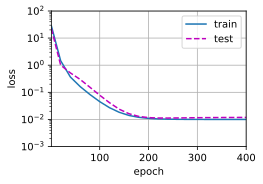

In [31]:
# 三阶多项式函数拟合(正常)
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
''' 
n_train = 100
训练特征 poly_features[:n_train, :4]  (200,20) 中的前100行,4列  之所以4列是因为是三阶多项式拟合
测试特征 poly_features[n_train:, :4]  (200,20) 中的后100行,4列  从多项式特征中选择前4个维度
训练标签 labels[:n_train] (200) 前100行
测试标签 labels[n_train:] (200) 后100行
'''
# train(train_features, test_features, train_labels, test_labels,num_epochs=400)
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:]) # 返回权重

weight: [[3.100349  3.7032094]]


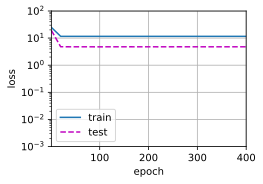

In [32]:
# 线性函数拟合(⽋拟合)
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:]) # 维度低,无法拟合三阶多项式,训练不出来

weight: [[ 4.99862671e+00  1.24456668e+00 -3.42393517e+00  5.25449562e+00
   1.46364376e-01  1.23676443e+00  1.39075264e-01 -3.46590416e-03
  -2.42724735e-02 -8.27922225e-02 -1.05850846e-01 -2.08031535e-02
  -2.46063620e-02 -1.63390815e-01  6.38427809e-02 -2.20440894e-01
  -1.80666998e-01 -2.37634908e-02 -1.35329962e-01  1.28132224e-01]]


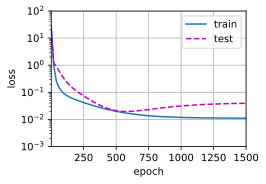

In [33]:
# ⾼阶多项式函数拟合(过拟合)
# 从多项式特征中选取所有维度
''' 
没有⾜够的数据⽤于学到⾼阶系数应该具有接近于零的值
因此，这个过于复杂的模型会轻易受到训练数据中噪声的影响
虽然训练损失可以有效地降低，但测试损失仍然很⾼
结果表明，复杂模型对数据造成了过拟合
'''
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500) # 20维度拟合三阶多项式

In [34]:
''' 
 ⼩结
• ⽋拟合是指模型⽆法继续减少训练误差。过拟合是指训练误差远⼩于验证误差。
• 由于不能基于训练误差来估计泛化误差，因此简单地最⼩化训练误差并不⼀定意味着泛化误差的减⼩。
  机器学习模型需要注意防⽌过拟合，即防⽌泛化误差过⼤。
• 验证集可以⽤于模型选择，但不能过于随意地使⽤它。
• 我们应该选择⼀个复杂度适当的模型，避免使⽤数量不⾜的训练样本
'''

' \n ⼩结\n• ⽋拟合是指模型⽆法继续减少训练误差。过拟合是指训练误差远⼩于验证误差。\n• 由于不能基于训练误差来估计泛化误差，因此简单地最⼩化训练误差并不⼀定意味着泛化误差的减⼩。\n  机器学习模型需要注意防⽌过拟合，即防⽌泛化误差过⼤。\n• 验证集可以⽤于模型选择，但不能过于随意地使⽤它。\n• 我们应该选择⼀个复杂度适当的模型，避免使⽤数量不⾜的训练样本\n'